# 3D Occupancy Grid with ibeo Lux Laserscanner Data from BlenSor

[BlenSor](http://blensor.org) is a Laserscanner simulation Toolbox, based on Blender, Thanks Michael!

```
Michael Gschwandtner, Roland Kwitt, Andreas Uhl and Wolfgang Pree,  BlenSor: Blender Sensor Simulation Toolbox , In G. Bebis, R. Boyle, B. Parvin, D. Koracin, R. Chung and R. Hammoud, editors, Advances in Visual Com- puting: 7th International Symposium, (ISVC 2011), Volume 6939/2011, pp. 199-208, Springer Verlag, 2011
```

In [202]:
import numpy as np
import time
import pandas as pd
import pickle

In [203]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import seaborn as sns
sns.set_style('whitegrid')

### Create Empty Grid

In [204]:
l = 50.0 # Länge m
b = 35.0  # Breite m
h = 3.0  # Höhe m

grid_res = 0.1 # Resolution m/gridcell

In [205]:
print('%.1fmio Grid Cells' % ((l*b*h)/grid_res**3/1e6))

5.2mio Grid Cells


## Generate a LogOdds Grid

Why LogOdds? Numerically stable around $p=0$ and $p=1$ and reduces the mathematical efford to update the Grid (Bayes Rule) to just an addition!

So an initial uncertainty ($p=0.5$) is a zero in LogOdds. That's fine, because it is a very fast initialization of the grid!
In order to store log(odds), we need negative values and decimal values. And `float32` ist fastest: http://stackoverflow.com/questions/15340781/python-numpy-data-types-performance

So let's use it!

In [206]:
print "%ix%ix%i Grid" % (l/grid_res, b/grid_res, h/grid_res)
startTime = time.time()

grid = np.zeros((l/grid_res, b/grid_res, h/grid_res), dtype=np.float32) # Log Odds Grid must be initialized with zeros!

print "Stats: %.2fs, %.2fGB" % (time.time() - startTime, (grid.nbytes/1024.0**2))

500x350x30 Grid
Stats: 0.00s, 20.03GB


/Users/paul/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Function for 3D View of the Occupancy Grid

In [207]:
def plot3Dgrid(grid, az, el):
    # plot the surface
    plt3d = plt.figure(figsize=(12, 6)).gca(projection='3d', axisbg='w')

    # create x,y
    ll, bb = np.meshgrid(range(grid.shape[1]), range(grid.shape[0]))

    for z in range(grid.shape[2]):
        if not (np.max(grid[:,:,z])==np.min(grid[:,:,z])): # unberührte Ebenen nicht darstellen
            cp = plt3d.contourf(ll, bb, grid[:,:,z], offset = z, alpha=0.3, cmap=cm.Greens)

    cbar = plt.colorbar(cp, shrink=0.7, aspect=20)
    cbar.ax.set_ylabel('$P(m|z,x)$')
    
    plt3d.set_xlabel('X')
    plt3d.set_ylabel('Y')
    plt3d.set_zlabel('Z')
    plt3d.set_xlim3d(0, grid.shape[0])
    plt3d.set_ylim3d(0, grid.shape[1])
    plt3d.set_zlim3d(0, grid.shape[2])
    #plt3d.axis('equal')
    plt3d.view_init(az, el)
    return plt3d

## 3D Rotation Matrix in `yaw, pitch, roll` convention

see "[[Tutorial] Rotationsmatrix und Quaternion einfach erklärt in DIN70000 ZYX Konvention](http://www.cbcity.de/tutorial-rotationsmatrix-und-quaternion-einfach-erklaert-in-din70000-zyx-konvention)" for more details

In [208]:
def Rypr(y, p, r, in_deg=False):
    '''
    Rotationsmatrix für y=yaw, p=pitch, r=roll in degrees
    '''
    if in_deg:
        # from Degree to Radians
        y = y*np.pi/180.0
        p = p*np.pi/180.0
        r = r*np.pi/180.0

    Rr = np.matrix([[1.0, 0.0, 0.0],[0.0, np.cos(r), -np.sin(r)],[0.0, np.sin(r), np.cos(r)]])
    Rp = np.matrix([[np.cos(p), 0.0, np.sin(p)],[0.0, 1.0, 0.0],[-np.sin(p), 0.0, np.cos(p)]])
    Ry = np.matrix([[np.cos(y), -np.sin(y), 0.0],[np.sin(y), np.cos(y), 0.0],[0.0, 0.0, 1.0]])
    
    return Ry*Rp*Rr

## Integrate a measurement with BRESENHAM Algorithm

Based on:
```
Amanatides, J., & Woo, A. (1987). A fast voxel traversal algorithm for ray tracing. Proceedings of EUROGRAPHICS, i. Retrieved from http://www.cse.yorku.ca/~amana/research/grid.pdf
```

Here is a Python Implementation of BRESENHAM Algorithm: https://gist.github.com/salmonmoose/2760072

In [209]:
def bresenham3D(startPoint, endPoint):
    # by Anton Fletcher
    # Thank you!
    path = [] 
    
    startPoint = [int(startPoint[0]),int(startPoint[1]),int(startPoint[2])]
    endPoint = [int(endPoint[0]),int(endPoint[1]),int(endPoint[2])]

    steepXY = (np.abs(endPoint[1] - startPoint[1]) > np.abs(endPoint[0] - startPoint[0]))
    if(steepXY):   
        startPoint[0], startPoint[1] = startPoint[1], startPoint[0]
        endPoint[0], endPoint[1] = endPoint[1], endPoint[0]

    steepXZ = (np.abs(endPoint[2] - startPoint[2]) > np.abs(endPoint[0] - startPoint[0]))
    if(steepXZ):
        startPoint[0], startPoint[2] = startPoint[2], startPoint[0]
        endPoint[0], endPoint[2] = endPoint[2], endPoint[0]

    delta = [np.abs(endPoint[0] - startPoint[0]), np.abs(endPoint[1] - startPoint[1]), np.abs(endPoint[2] - startPoint[2])]

    errorXY = delta[0] / 2
    errorXZ = delta[0] / 2

    step = [
      -1 if startPoint[0] > endPoint[0] else 1,
      -1 if startPoint[1] > endPoint[1] else 1,
      -1 if startPoint[2] > endPoint[2] else 1
    ]

    y = startPoint[1]
    z = startPoint[2]

    for x in range(startPoint[0], endPoint[0], step[0]):
        point = [x, y, z]

        if(steepXZ):
            point[0], point[2] = point[2], point[0]
        if(steepXY):
            point[0], point[1] = point[1], point[0]

        #print (point)


        errorXY -= delta[1]
        errorXZ -= delta[2]

        if(errorXY < 0):
            y += step[1]
            errorXY += delta[0]

        if(errorXZ < 0):
            z += step[2]
            errorXZ += delta[0]

        path.append(point)

    return path

## Function which integrates the Measurements via Inverse Sensor Model

Values for hit and miss probabilities are taken from

    Hornung, A., Wurm, K. M., Bennewitz, M., Stachniss, C., & Burgard, W. (2013). OctoMap: an efficient probabilistic 3D mapping framework based on octrees. Autonomous Robots, 34(3), 189–206. doi:10.1007/s10514-012-9321-0


In [210]:
# in LogOdds Notation!
loccupied = 0.85
lfree = -0.4

lmin = -2.0
lmax = 3.5

In [211]:
def insertPointcloudBRESENHAM(grid, grid_res, tSensor, XYZendpoints):
    '''
    grid: Occupancy Grid
    grid_res: Occupancy Grid Resolution
    tSensor: x,y,z coordinate of sensor origin
    XYZendpoints: x,y,z coordinate array of scan endpoints
    '''
    xe = XYZendpoints[:,0]/grid_res
    ye = XYZendpoints[:,1]/grid_res
    ze = XYZendpoints[:,2]/grid_res
    
    xs = tSensor[0]/grid_res
    ys = tSensor[1]/grid_res
    zs = tSensor[2]/grid_res    
    
    for i,val in enumerate(xe):
        
        # Insert Endpoints
        y=int(xe[i])
        x=int(ye[i]) # !!! Koordinatenswitch zwischen X & Y
        z=int(ze[i])

        # Inverse Sensor Model
        grid[x,y,z] += loccupied # increase LogOdds Ratio

        if grid[x,y,z]>lmax: # clamping
            grid[x,y,z]=lmax

        
        # Grid cells in perceptual range of laserscanner
        for (y,x,z) in bresenham3D((xs,ys,zs), (xe[i], ye[i], ze[i])): # !!! Koordinatenswitch zwischen X & Y

            grid[x,y,z] += lfree # decrease LogOdds Ratio

            if grid[x,y,z]<lmin: # clamping
                grid[x,y,z]=lmin

    return grid

### Sensor Origin

The grid is 0-based, the scans are in global coordinates, so we shift the scans to some coordinates, that it will fit into the initialized Occupancy grid.

In [212]:
grid_shift = np.array([40.0, 8.0, 0.0])

### Load some Simulated Laserscanner Data

The data was generated with [Blensor](http://blensor.org):

1. Some `.pcd` were dumped
2. A `motion.pcd` was generated, which holds the position and orientation of the Laserscanner

In [213]:
motiondata = pd.read_csv('./scans/motion.pcd', delimiter=' ',
                         usecols=[1,5,7,9,11,13,15],
                         names=['timestamp','x','y','z','rot_x','rot_y','rot_z'],
                         index_col='timestamp')
motiondata.head()

,x,y,z,rot_x,rot_y,rot_z
timestamp,,,,,,
12.80,-34.281963,0.441563,2.278724,5.197000e-07,-1.221731,-0.436332
12.84,-34.241825,0.441563,2.278724,5.197000e-07,-1.221731,-0.436332
12.88,-34.201687,0.441563,2.278724,5.197000e-07,-1.221731,-0.436332
12.92,-34.161549,0.441563,2.278724,5.197000e-07,-1.221731,-0.436332
12.96,-34.121410,0.441563,2.278724,5.197000e-07,-1.221731,-0.436332


Every `timestamp` with arbitrary `x, y, z` location and `rot_x, rot_y, rot_z` Rotation of the sensor has a scan:

In [214]:
len(motiondata)

340

Rotation und Translation in homogenen Koordinaten, d.h. es kann alles über Matrizenmultiplikation gemacht werden.

$$\left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right]_\text{Global} = \underbrace{\left[\begin{matrix} R_{3x3} & t_{1x3} \\ 0 & 1\end{matrix}\right]}_{_T} \cdot \left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right]_\text{Lokal}$$

wobei $R$ die Rotationsmatrix ist und $t$ der Verschiebungsvektor

In [215]:
m_start = 320 # Startnummer der Dateien (entspricht Frame in Blender)
pointcloud = pd.DataFrame()

T = np.eye(4)
T[:3,:3] = Rypr(0.0, 0.0, 0.0, in_deg=True) # Rotationsmatrix

for m in range(len(motiondata)):
    # some ibeo lux simulated measurements
    fname = './scans/scan_%i.pcd' % (m+m_start)
    #print('Lade %s' % fname)
    data = pd.read_csv(fname, delimiter=' ',
                       skiprows=11, names=['X','Y','Z','rgb','label'])
    #data.head(5)
    
    # Filter with euclidean Distance from scanner
    max_dist = 15.0
    min_dist = 1.5
    data['dist'] = np.sqrt(data.X**2.0 + data.Y**2.0 + data.Z**2.0)
    data = data[(data['dist']<max_dist) & (data['dist']>min_dist)]

    # Transformation von Lokal in Global
    t = np.array([motiondata.iloc[m].x, motiondata.iloc[m].y, motiondata.iloc[m].z])
    T[:3, 3] = t+grid_shift
    
    # Homogene Koordinatentransformation (Rotation+Translation)
    pcl_local_homogen = np.vstack([data[['X','Y','Z']].T, np.ones([1, len(data)])])
    pcl_global = np.dot(T, pcl_local_homogen)[:3, :].T
    
    
    grid = insertPointcloudBRESENHAM(grid, grid_res, t+grid_shift, pcl_global)
    pointcloud = pointcloud.append(pd.DataFrame(pcl_global, columns=['x','y','z']), ignore_index=True)

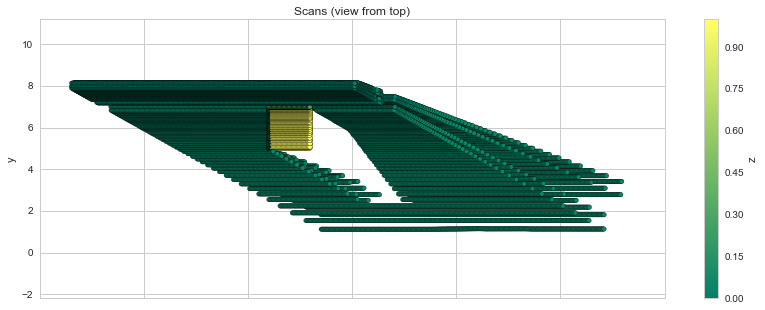

In [216]:
pointcloud.plot(x='x', y='y', c='z', kind='scatter', cmap='summer', figsize=(14,5))
plt.axis('equal')
plt.title('Scans (view from top)')

In [217]:
print('Maximale Pointcloud Abmessungen:')
print('x: %.2f %.2f' % (pointcloud.x.min(), pointcloud.x.max()))
print('y: %.2f %.2f' % (pointcloud.y.min(), pointcloud.y.max()))
print('z: %.2f %.2f' % (pointcloud.z.min(), pointcloud.z.max()))

Maximale Pointcloud Abmessungen:
x: 6.54 32.94
y: 1.12 8.16
z: -0.00 1.00


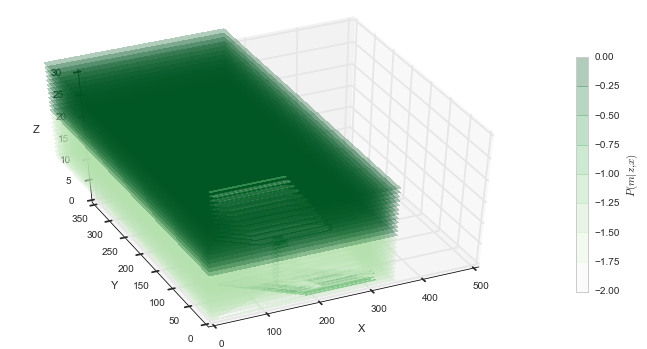

In [218]:
plot3Dgrid(grid, 45, -115)

### 2D Plot of Grid Layer Z

In [ ]:
@interact
def plotmultivargauss(z = widgets.FloatSliderWidget(min=0, max=np.max(grid.shape[2])-1, step=1, value=10, description="")):
    plt.figure(figsize=(l/2, b/2))
    plt.contourf(grid[:,:,z], cmap=cm.Greens)
    plt.axis('equal')
    plt.xlabel('X')
    plt.ylabel('Y')

### 3D Plot

In [ ]:
@interact
def plotmultivargauss(az = widgets.FloatSliderWidget(min=-90.0, max=90.0, step=1.0, value=45.0, description=""), \
                      el = widgets.FloatSliderWidget(min=-180.0, max=180.0, step=1.0, value=-115.0, description="")):

    plot3Dgrid(grid, az, el)

In [97]:
print('Max Grid Value (Log Odds): %.2f' % np.max(grid))
print('Min Grid Value (Log Odds): %.2f' % np.min(grid))

Max Grid Value (Log Odds): 3.50
Min Grid Value (Log Odds): -2.00


#### Dump the Occupancy Grid to file

In [ ]:
pklfile = open('occupancy-grid-LogOdds.pkl', 'wb')
pickle.dump(grid, pklfile)
pklfile.close()

## From LogOdds Occupancy Grid to Probability Grid

The conversion from LogOdds notation to probabilities could be achieved by following formula:

$$P(l) = 1-\cfrac{1}{1+e^{lo}}$$ with $lo$=LogOdds Value

In [ ]:
gridP = np.asarray([1.0-(1.0/(1.0+np.exp(lo))) for lo in grid])

In [ ]:
plot3Dgrid(gridP, 45, -115)
plt.savefig('3D-Occupancy-Grid.png')

In [ ]:
print('Max Grid Value (Probability): %.2f' % np.max(gridP))
print('Min Grid Value (Probability): %.2f' % np.min(gridP))

In [ ]:
print('Done.')

## Convolve the Map for Path Planning

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
blurmap = gaussian_filter(gridP, 0.4)

In [ ]:
plot3Dgrid(blurmap, 45, -115)

In [ ]:
print('Max Grid Value (Probability): %.2f' % np.max(blurmap))
print('Min Grid Value (Probability): %.2f' % np.min(blurmap))

#### Dump the convolved map

In [ ]:
pklfile = open('occupancy-grid-Blur.pkl', 'wb')
pickle.dump(blurmap, pklfile)
pklfile.close()